In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap, joblib, json, os
from pathlib import Path
from sklearn.metrics import precision_recall_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split

from src.features import get_data_and_preprocessor
shap.initjs()

In [2]:
# prep data
_, _, X_val_df, _, y_val = get_data_and_preprocessor()

X_samp, _, y_samp, _ = train_test_split(
    X_val_df, y_val,
    train_size=10_000,
    stratify=y_val,
    random_state=42
)

print(f'SHAP sample: {len(X_samp):,} rows: |'
      f'{y_samp.mean():.3%} positives')

ART_DIR = Path('assets/shap')
ART_DIR.mkdir(parents=True, exist_ok=True)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/Users/rodo/Desktop/banksafe-credit-risk/src/features.py:79: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(cleaned, errors="ignore")


SHAP sample: 10,000 rows: |1.790% positives


In [ ]:
# load models
MODELS = {
    'LogReg': dict(path='models/model_lr.joblib'),
    'LGBM': dict(path='models/model_lgbm.joblib')
}

for name, cfg in MODELS.items():
    cfg['pipe'] = joblib.load(cfg['path'])
    cfg['est'] = cfg['pipe'].named_steps[list(cfg['pipe'].named_steps)[-1]]
    cfg['proba'] = cfg['pipe'].predict_proba(X_samp)[:,1]

/Users/rodo/Desktop/banksafe-credit-risk/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [23]:
# explainers
preproc_lr = MODELS['LogReg']['pipe'][:-1]
X_enc = preproc_lr.transform(X_samp)

import scipy.sparse as sp
if sp.issparse(X_enc):
    X_enc_dense = X_enc.toarray()
else:
    X_enc_dense = X_enc

explainers = {
    'LGBM': shap.TreeExplainer(MODELS['LGBM']['est']),
    'LogReg': shap.LinearExplainer(
        MODELS['LogReg']['est'], X_enc_dense,
        feature_perturbation='interventional'
    )
}

/Users/rodo/Desktop/banksafe-credit-risk/.venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [24]:
shap_vals = {}

vals_lgbm = explainers["LGBM"].shap_values(X_enc_dense)
if isinstance(vals_lgbm, list):          
    vals_lgbm = vals_lgbm[1]             

if sp.issparse(vals_lgbm):
    vals_lgbm = vals_lgbm.toarray()

shap_vals["LGBM"] = np.asarray(vals_lgbm)   

vals_lr = explainers["LogReg"].shap_values(X_enc_dense)
if sp.issparse(vals_lr):
    vals_lr = vals_lr.toarray()

shap_vals["LogReg"] = np.asarray(vals_lr)   

for name, arr in shap_vals.items():
    print(f"{name}: SHAP array shape → {arr.shape}")

LGBM: SHAP array shape → (10000, 1117)
LogReg: SHAP array shape → (10000, 1117)


/Users/rodo/Desktop/banksafe-credit-risk/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [25]:
# global plots
feat_names = preproc_lr.get_feature_names_out()

def global_plots(name):
    vals = shap_vals[name]

    shap.summary_plot(
        vals, X_enc_dense, feature_names=feat_names,
        plot_type='bar', show=False, max_display=20,
        color_bar=False, title=f"{name} - top features"
    )
    plt.tight_layout()
    plt.savefig(ART_DIR / f'{name}_bar.png', dpi=150)
    plt.close()

    shap.summary_plot(
        vals, X_enc_dense, feature_names=feat_names,
        show=False, max_display=20, title=f'{name} - beeswarm'
    )
    plt.tight_layout()
    plt.savefig(ART_DIR / f'{name}_beeswarm.png', dpi=150)
    plt.close()

for m in MODELS:
    global_plots(m)

(pd.DataFrame({
    'feature': feat_names,
    'mean_abs_SHAP_LGBM': np.abs(shap_vals['LGBM']).mean(0),
    'mean_abs_SHAP_LogReg': np.abs(shap_vals['LogReg']).mean(0)
}).set_index('feature').to_csv(ART_DIR / 'global_shap_stats.csv'))

print('Global SHAP artifacts saved in ->', ART_DIR)

Global SHAP artifacts saved in -> assets/shap


In [26]:
# dependence plots
TOP_K = 6
top_idx = np.argsort(np.abs(shap_vals['LGBM']).mean(0))[-TOP_K:][::-1]

for i in top_idx:
    shap.dependence_plot(
        i, shap_vals['LGBM'], X_enc_dense,
        feature_names=feat_names, interaction_index=None,
        show=False, title=f'LGBM dependence: {feat_names[i]}'
    )
    plt.tight_layout()
    safe_name = feat_names[i].replace('/','_')[:40]
    plt.savefig(ART_DIR / f'dep_LGBM_{safe_name}.png', dpi=150)
    plt.close()
print('Dependence plots saved')

Dependence plots saved


In [28]:
# local explanations
proba_LGBM = MODELS['LGBM']['proba']
y_pred = (proba_LGBM>=0.15).astype(int)

cases = {
    'TP': np.where((y_pred==1)&(y_samp==1))[0][:1],
    'FP': np.where((y_pred==1)&(y_samp==0))[0][:1],
    'FN': np.where((y_pred==0)&(y_samp==1))[0][:1],
    'Border': [np.abs(proba_LGBM - 0.15).argmin()]
}

exp_val = explainers['LGBM'].expected_value

if isinstance(exp_val, (list, np.ndarray)):
    exp_val = exp_val[1]

for label, idx_arr in cases.items():
    idx = idx_arr[0]
    
    expl_row = shap.Explanation(
        values=shap_vals['LGBM'][idx],
        base_values=exp_val,
        data=X_enc_dense[idx],
        feature_names=feat_names,
    )

    shap.plots.waterfall(expl_row, max_display=15, show=False)
    plt.title(f'LGBM {label} - row {idx}')
    plt.tight_layout()
    plt.savefig(ART_DIR / f'local_{label}_{idx}.png', dpi=150)
    plt.close()

print('Local waterplots saved')

Local waterplots saved


In [29]:
# pr curve
plt.figure(figsize=(5,4))
prec, rec, _ = precision_recall_curve(y_samp, proba_LGBM)
plt.plot(rec, prec, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LightGBM PR curve (validation sample)')
plt.grid(ls=':')
plt.tight_layout()
plt.savefig(ART_DIR / 'LGBM_PR_curve.png', dpi=150)
plt.close()

print('Precision-recall curva saved!')

Precision-recall curva saved!


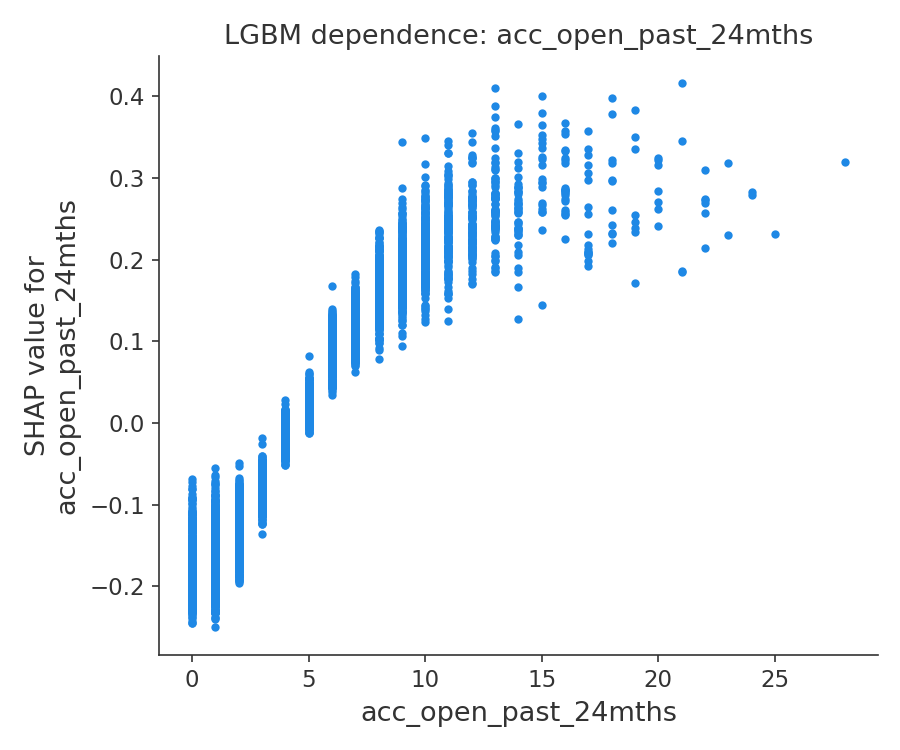

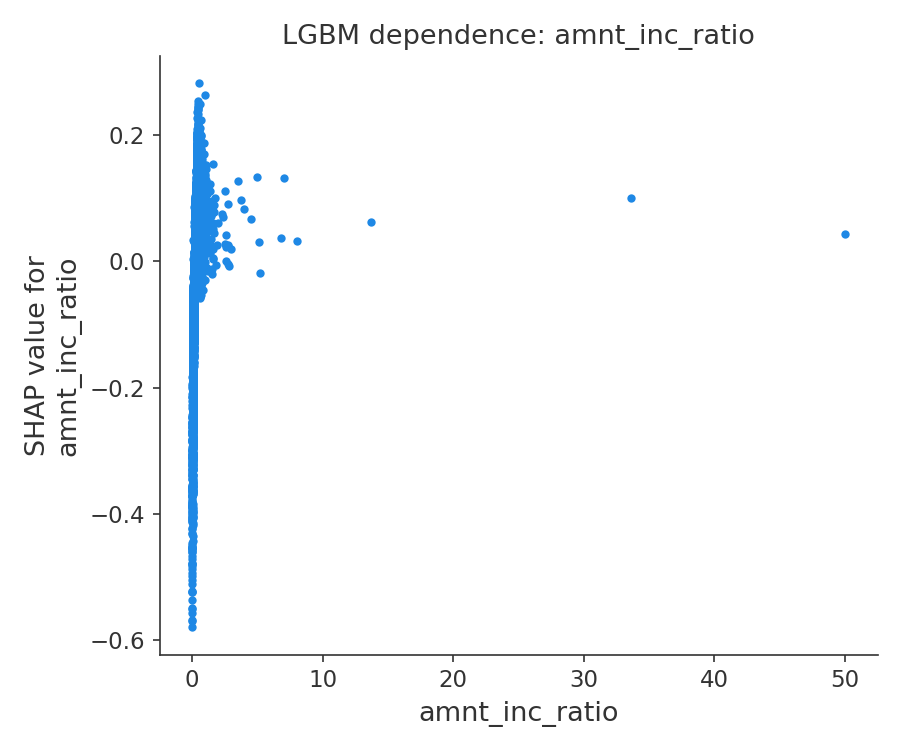

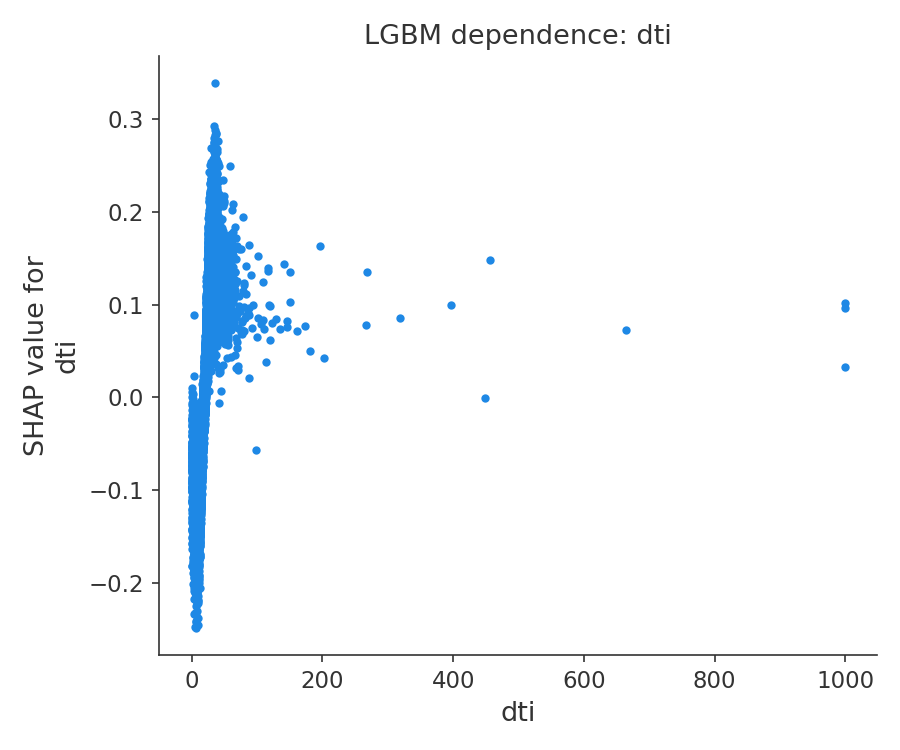

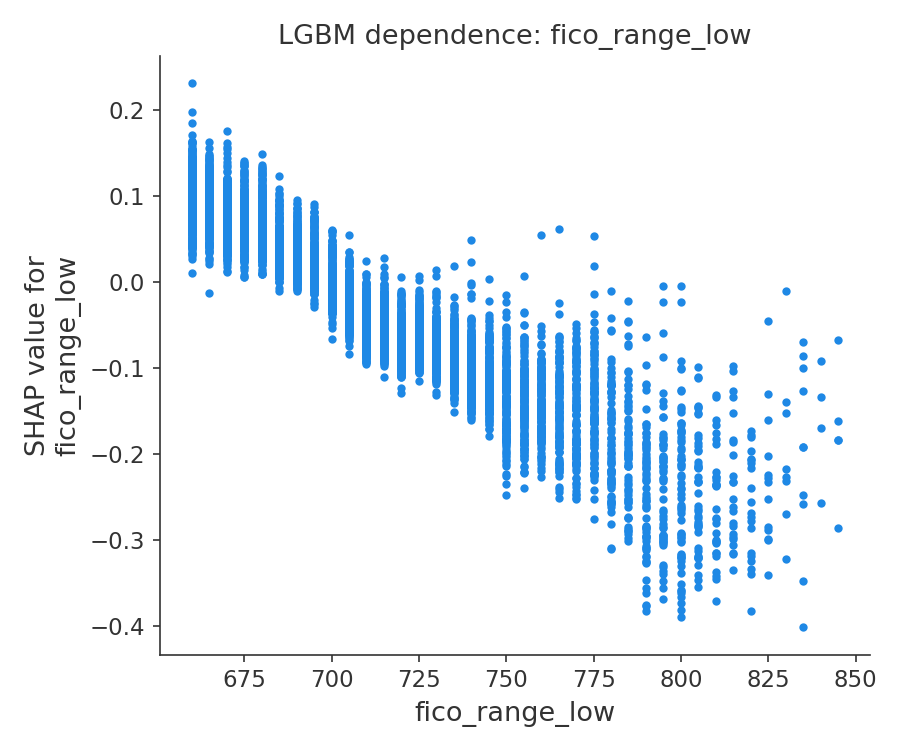

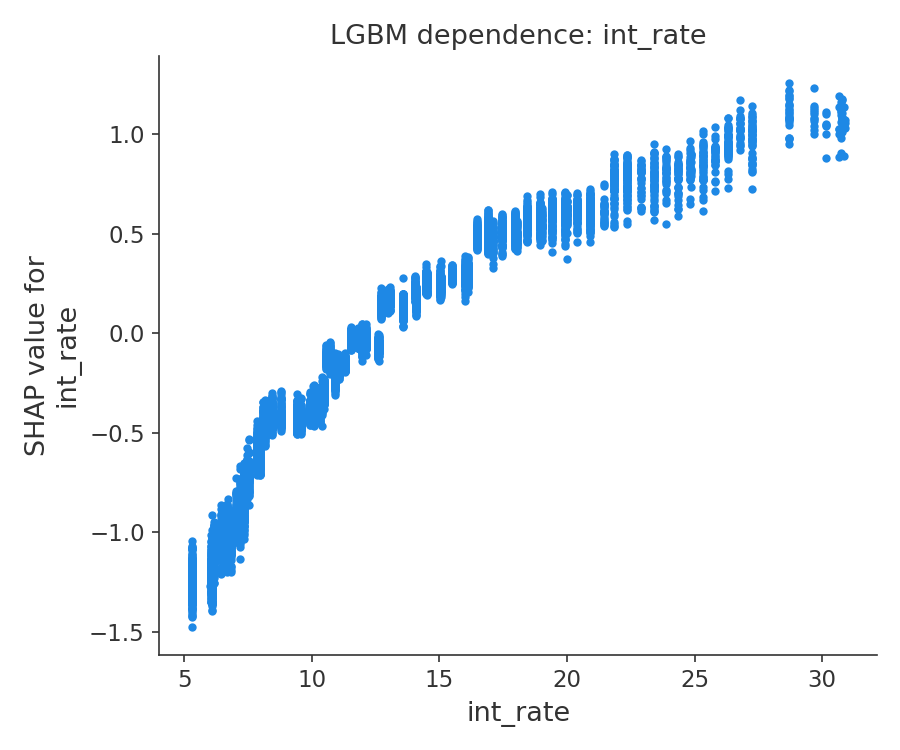

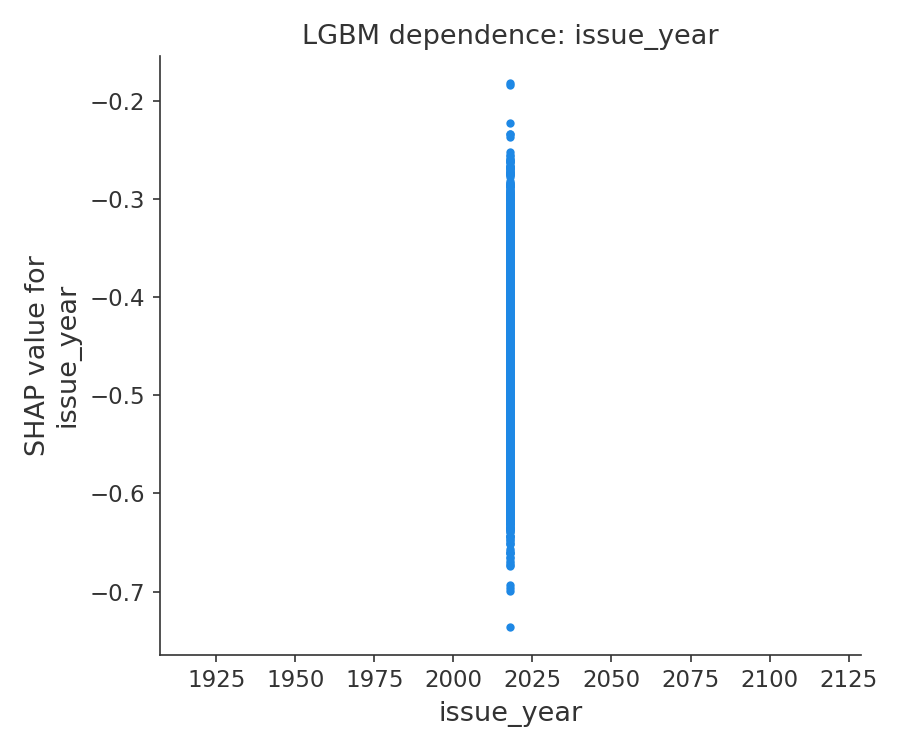

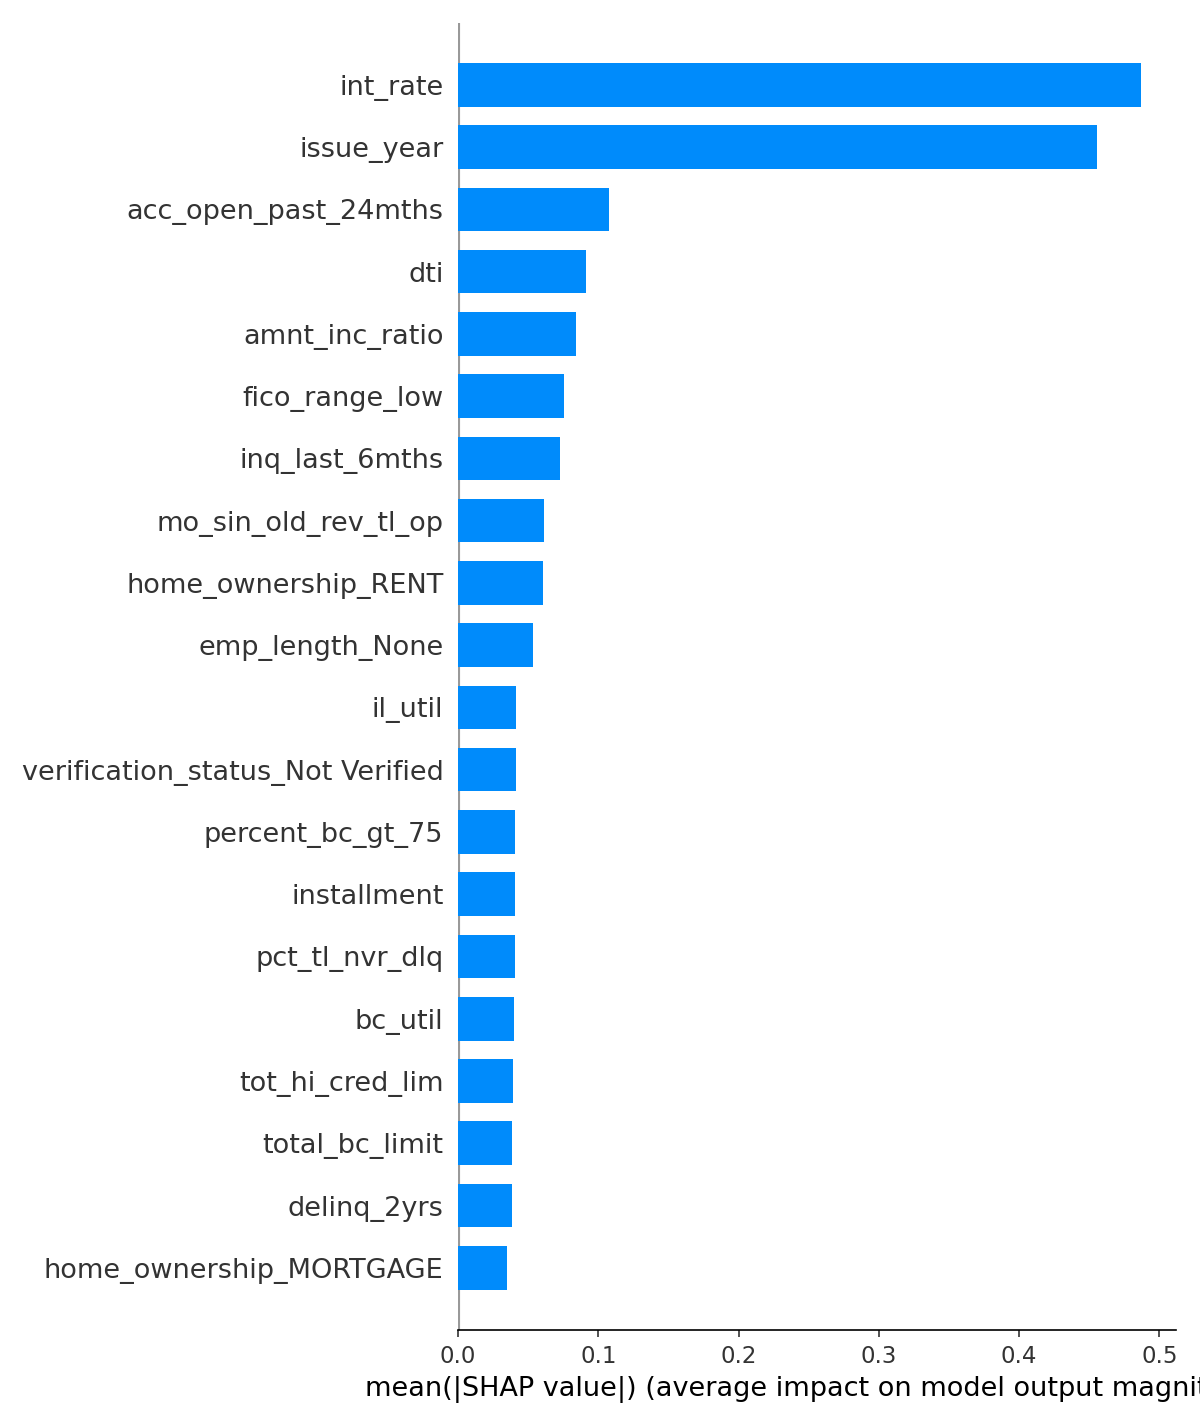

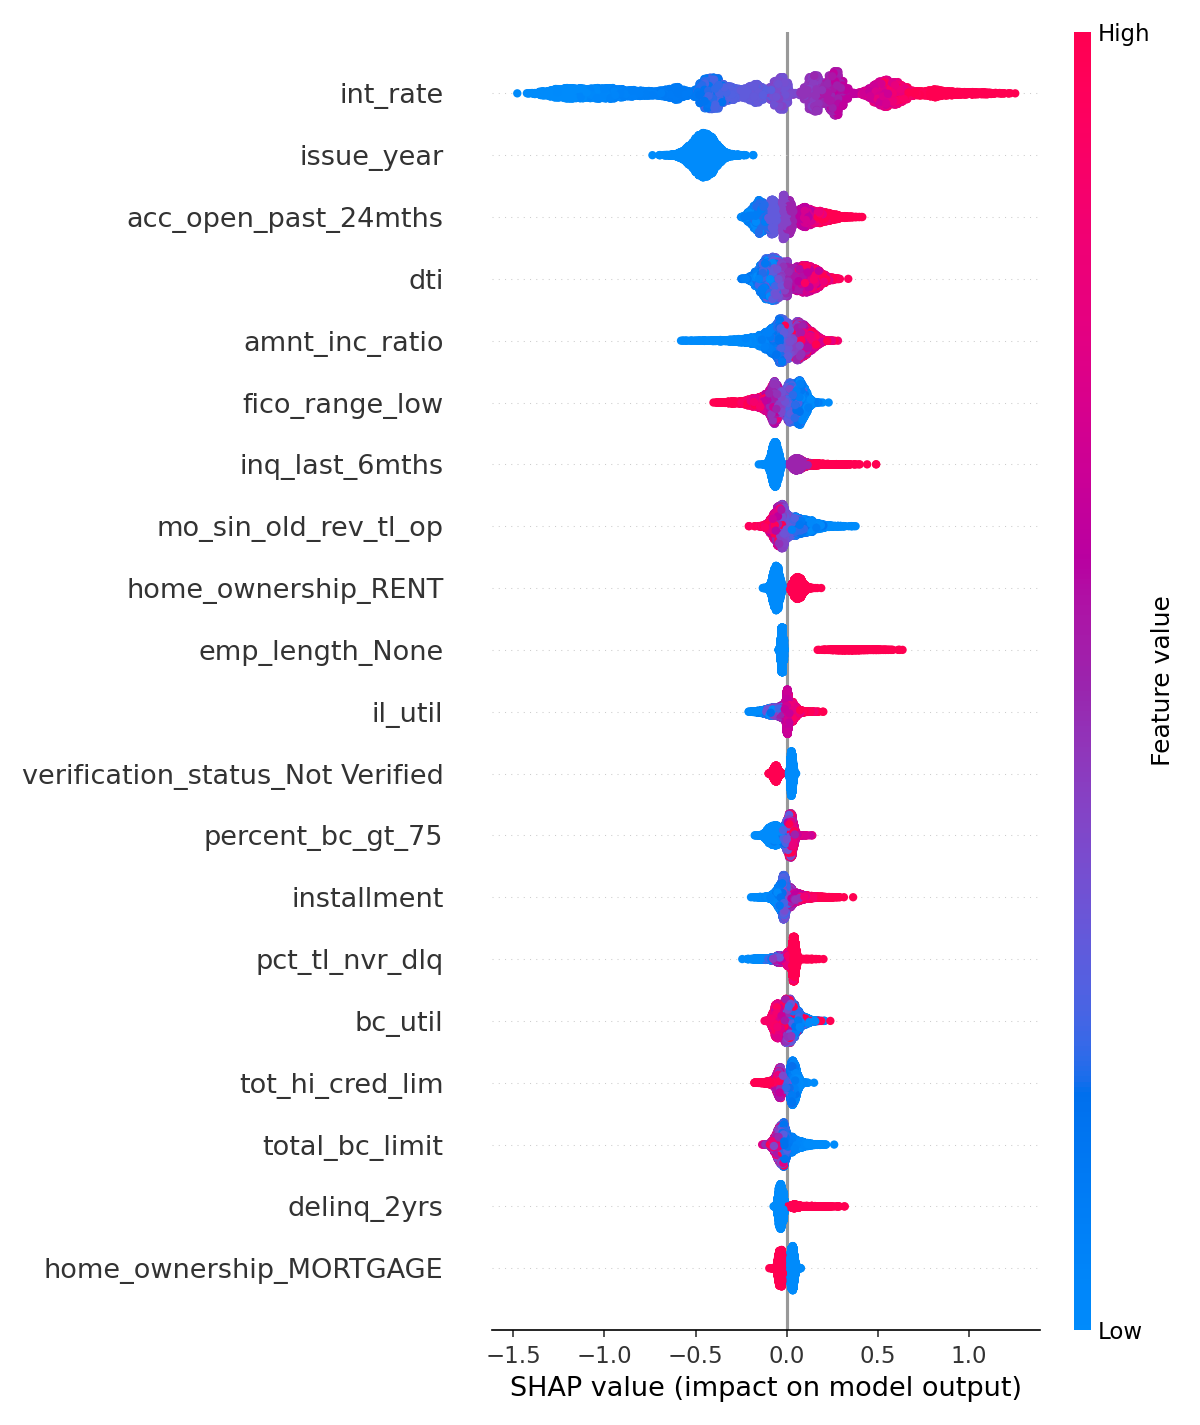

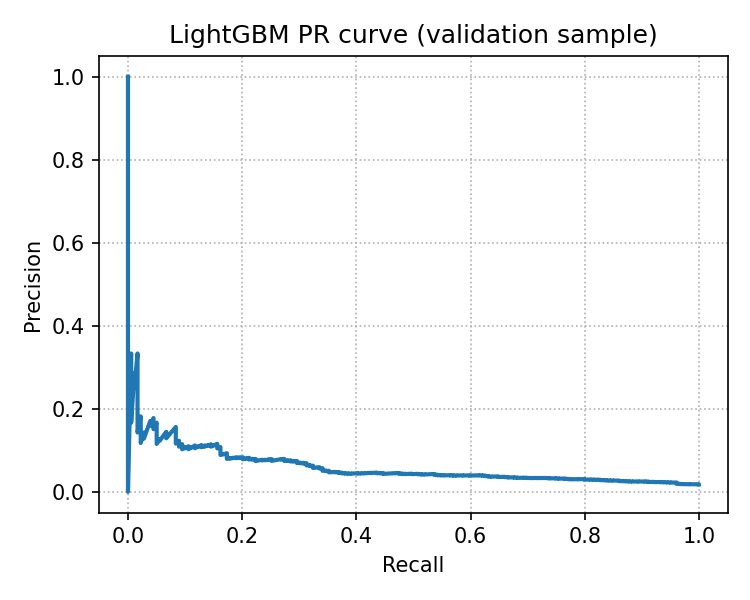

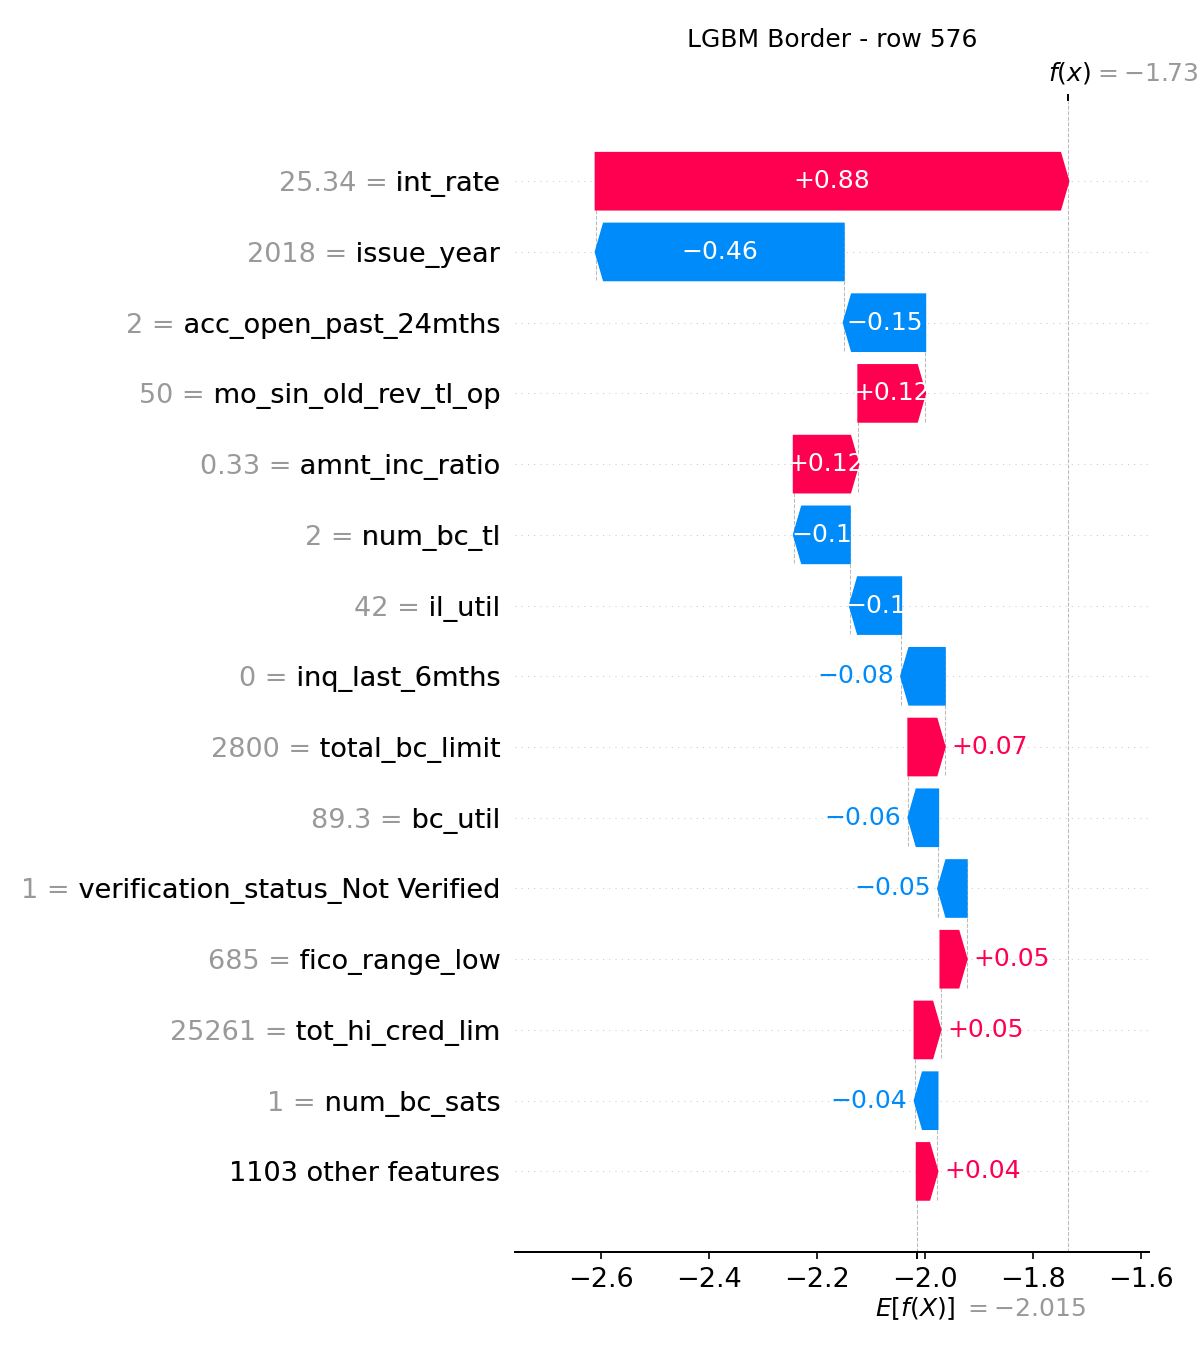

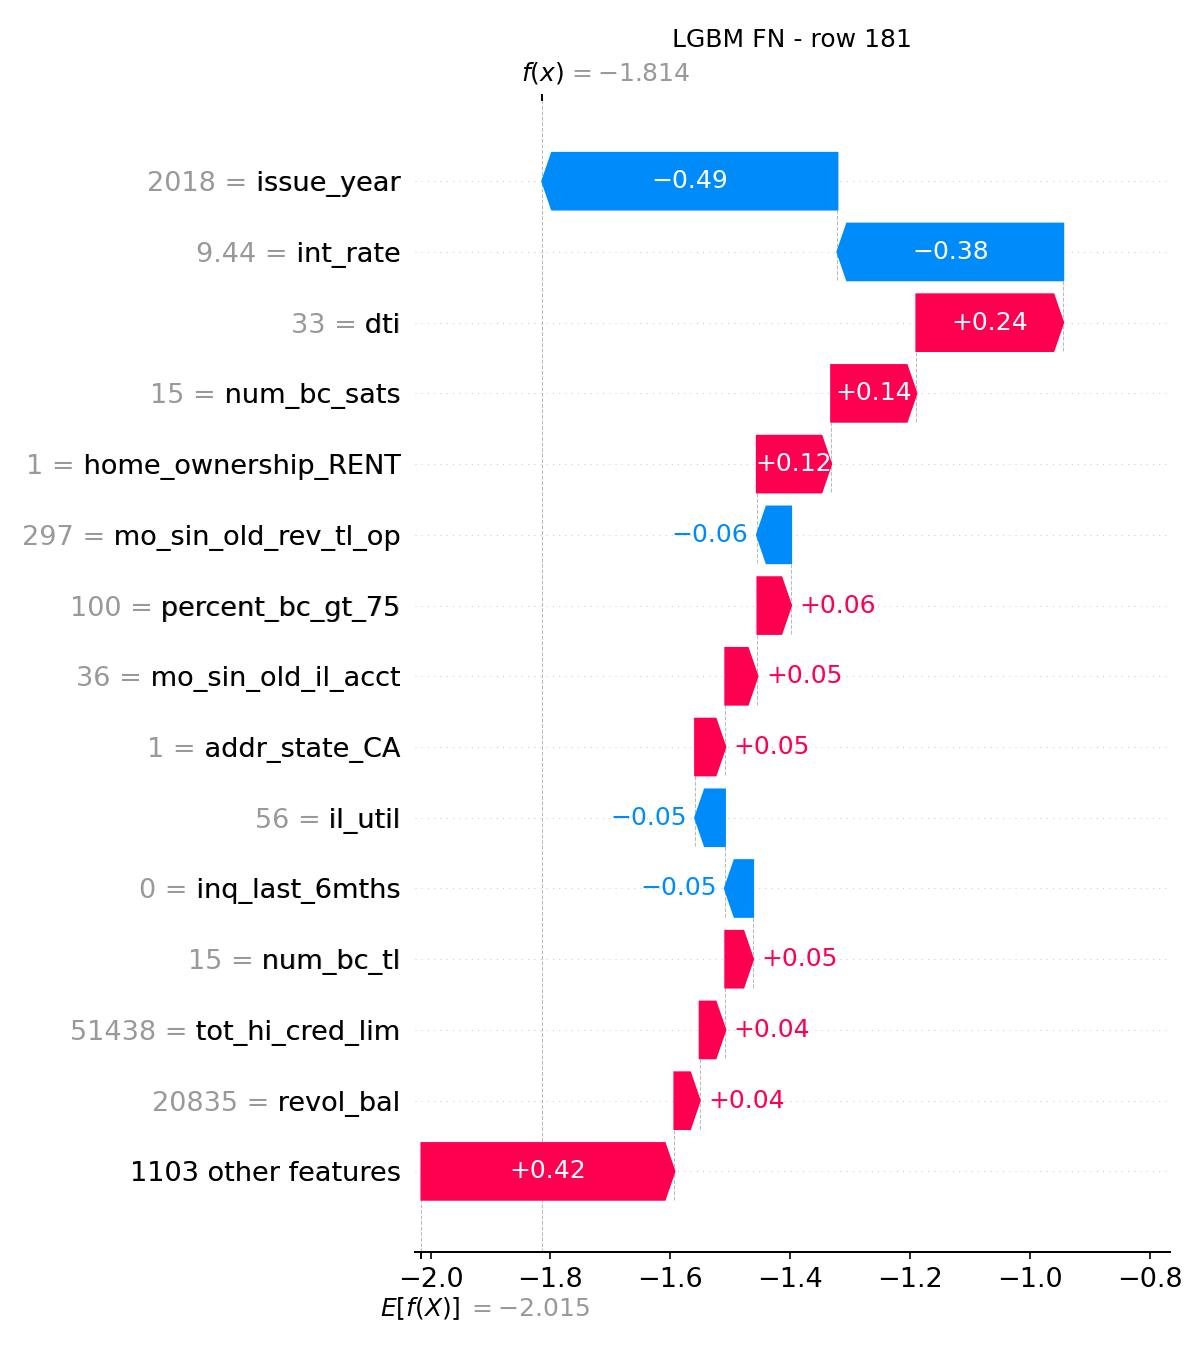

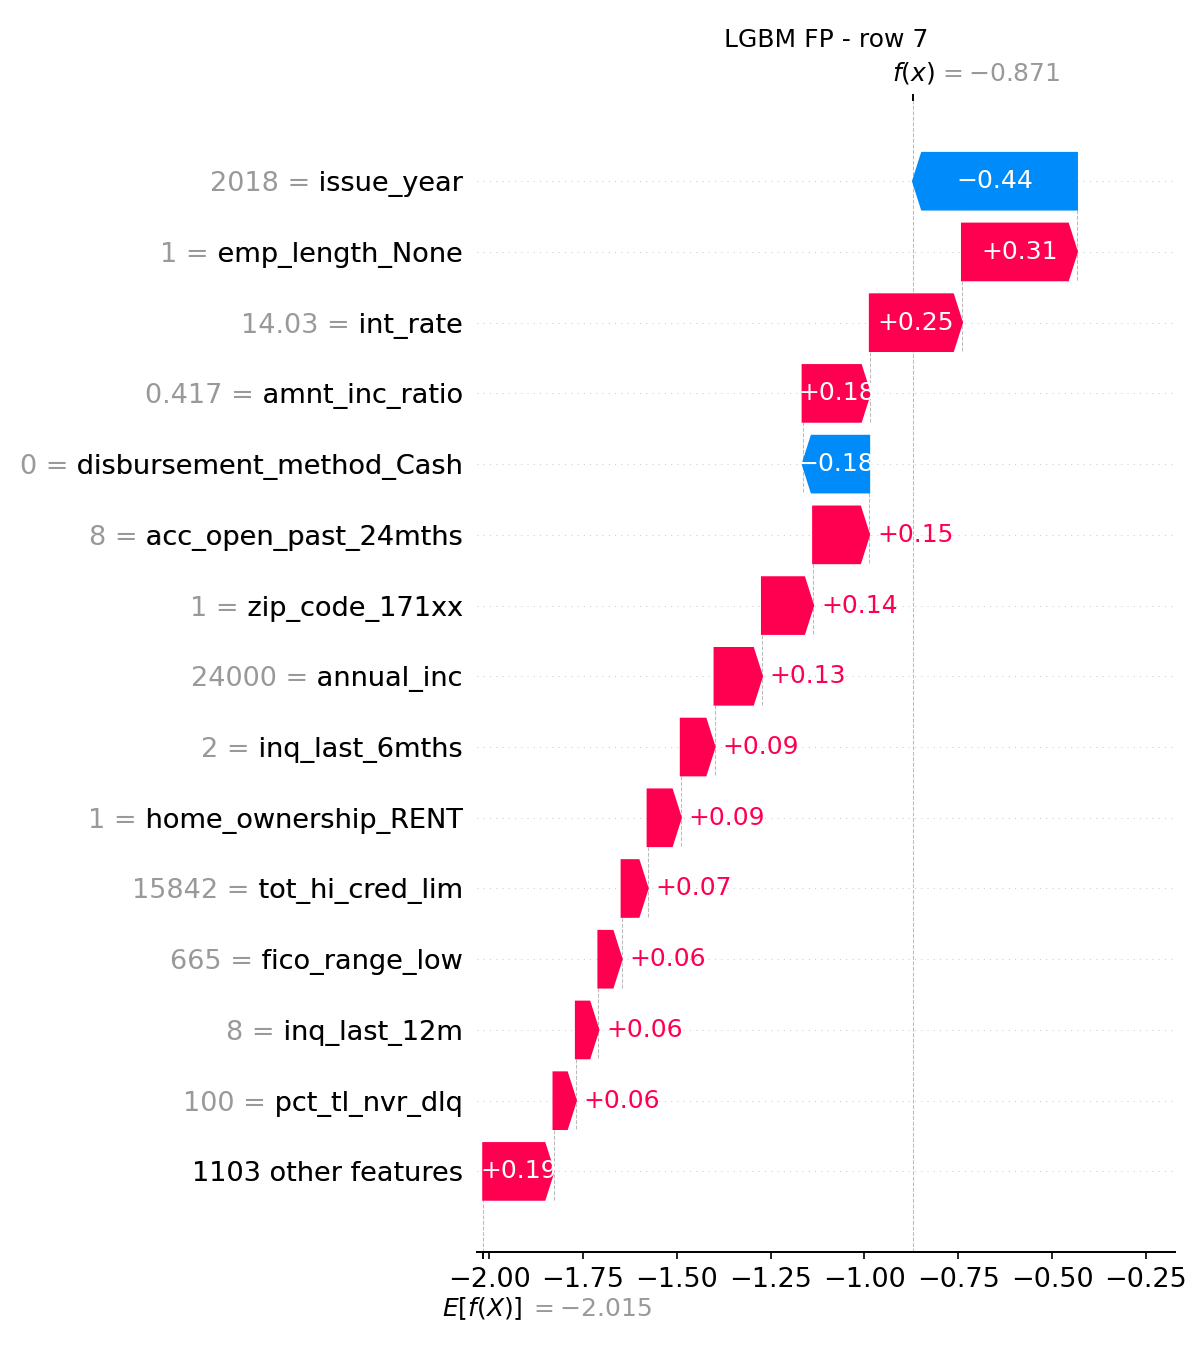

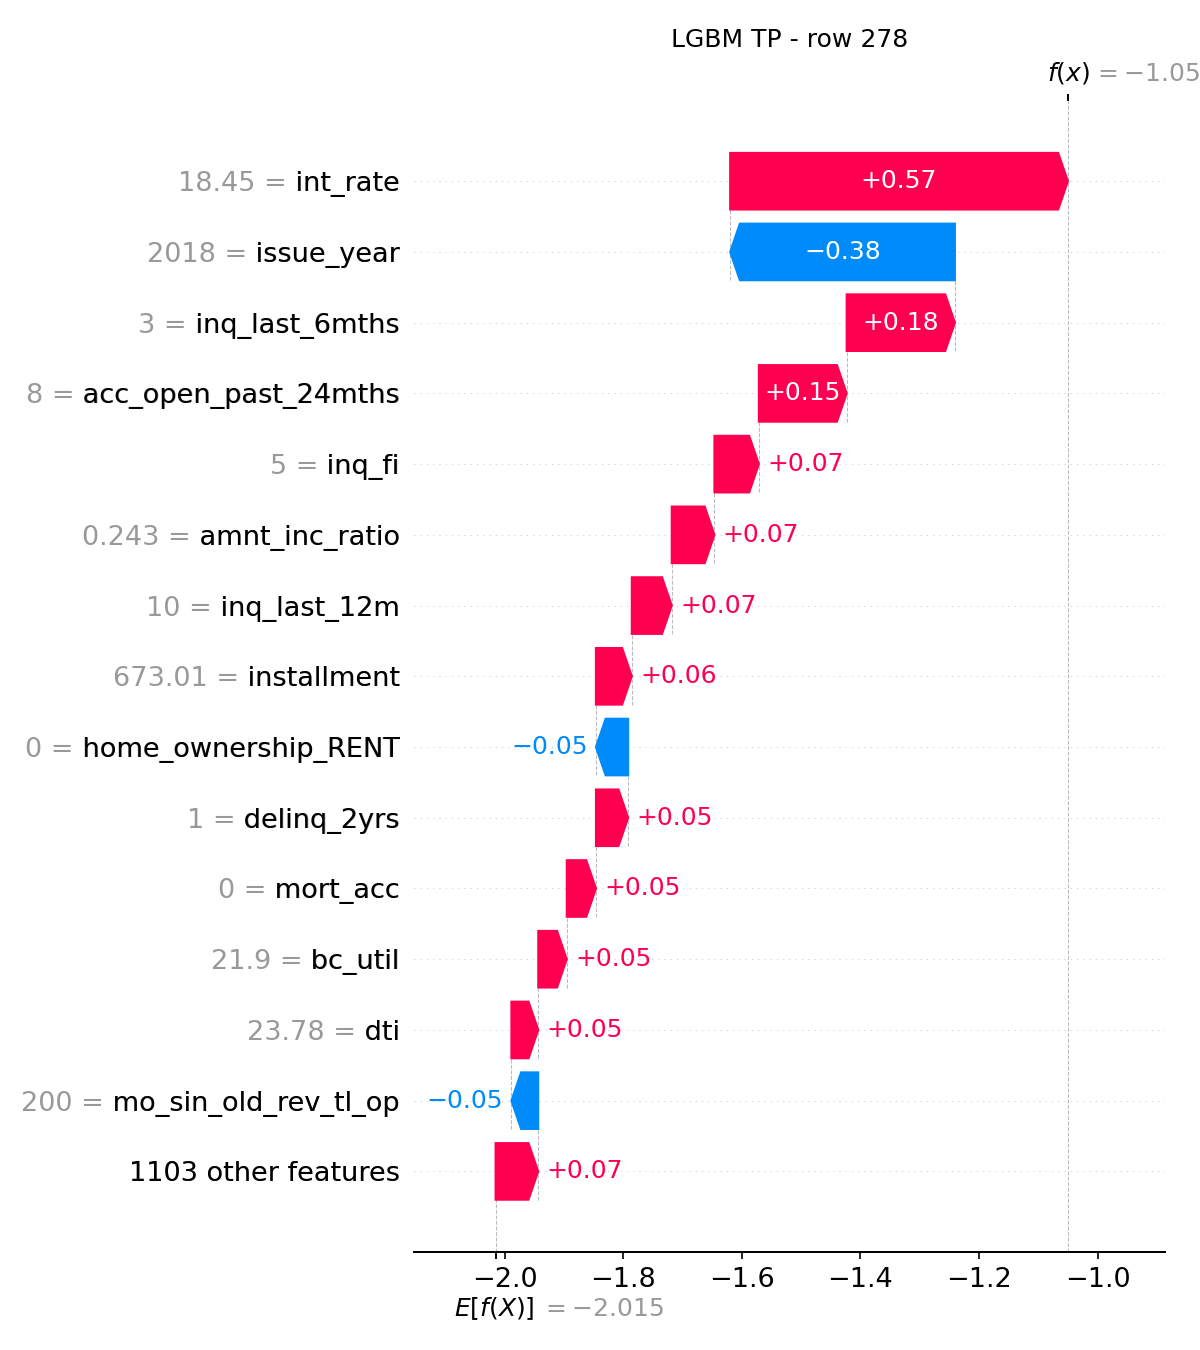

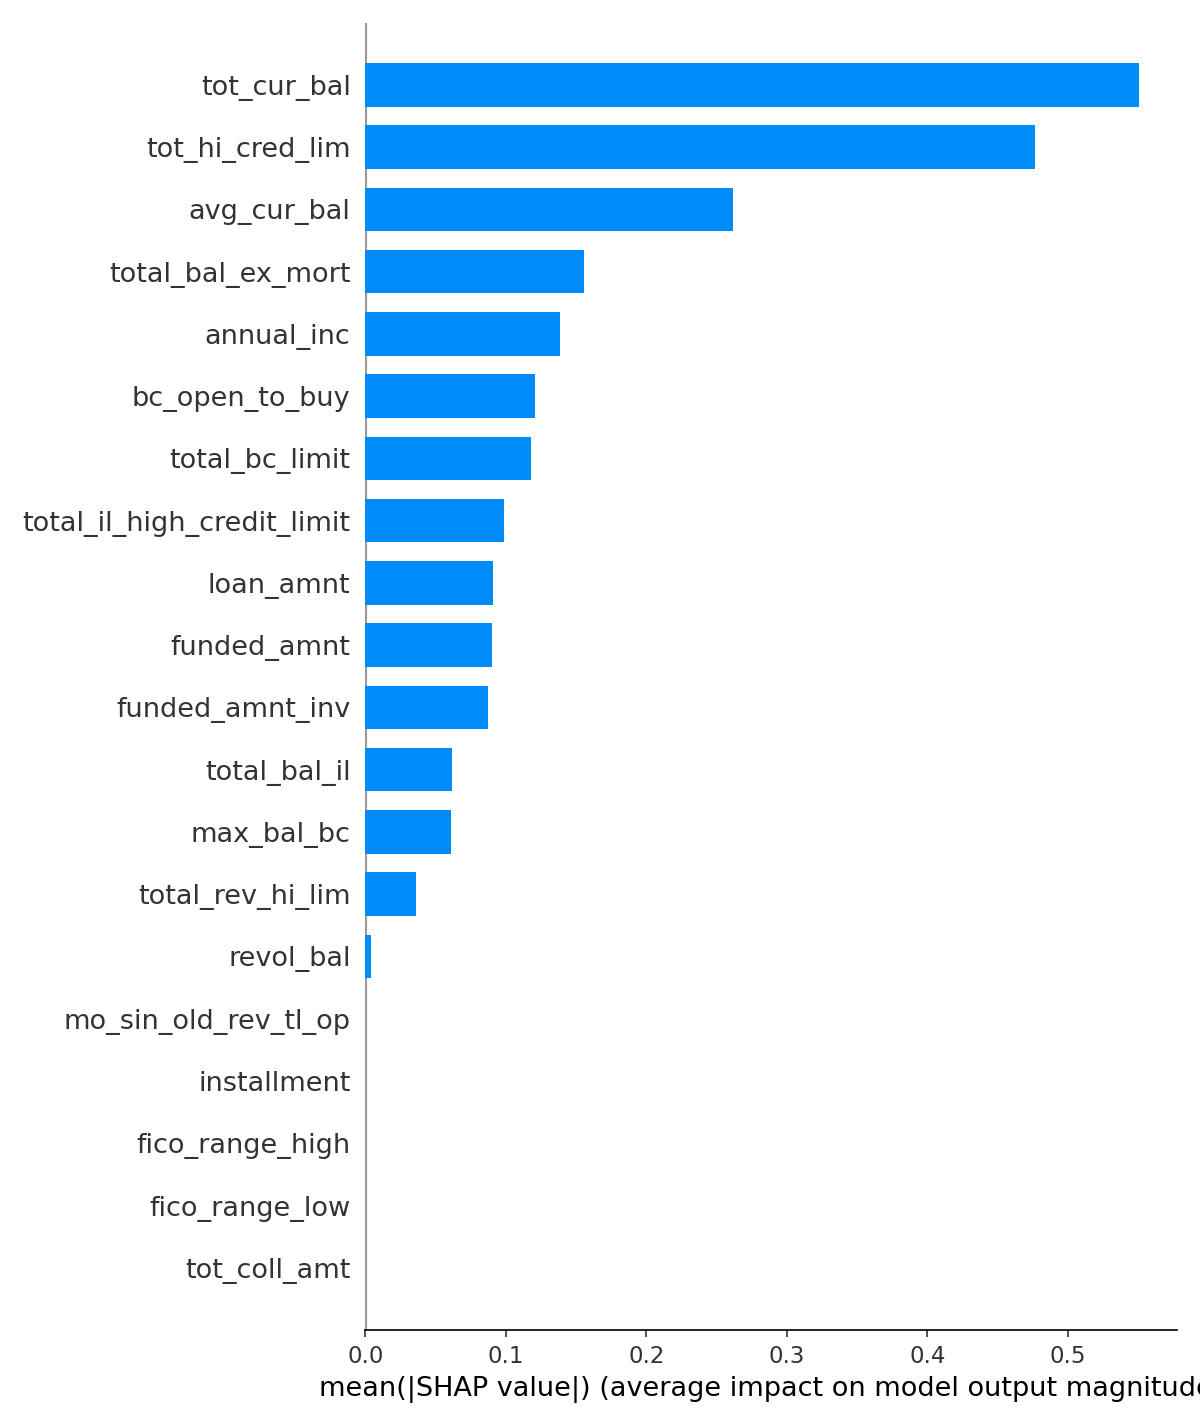

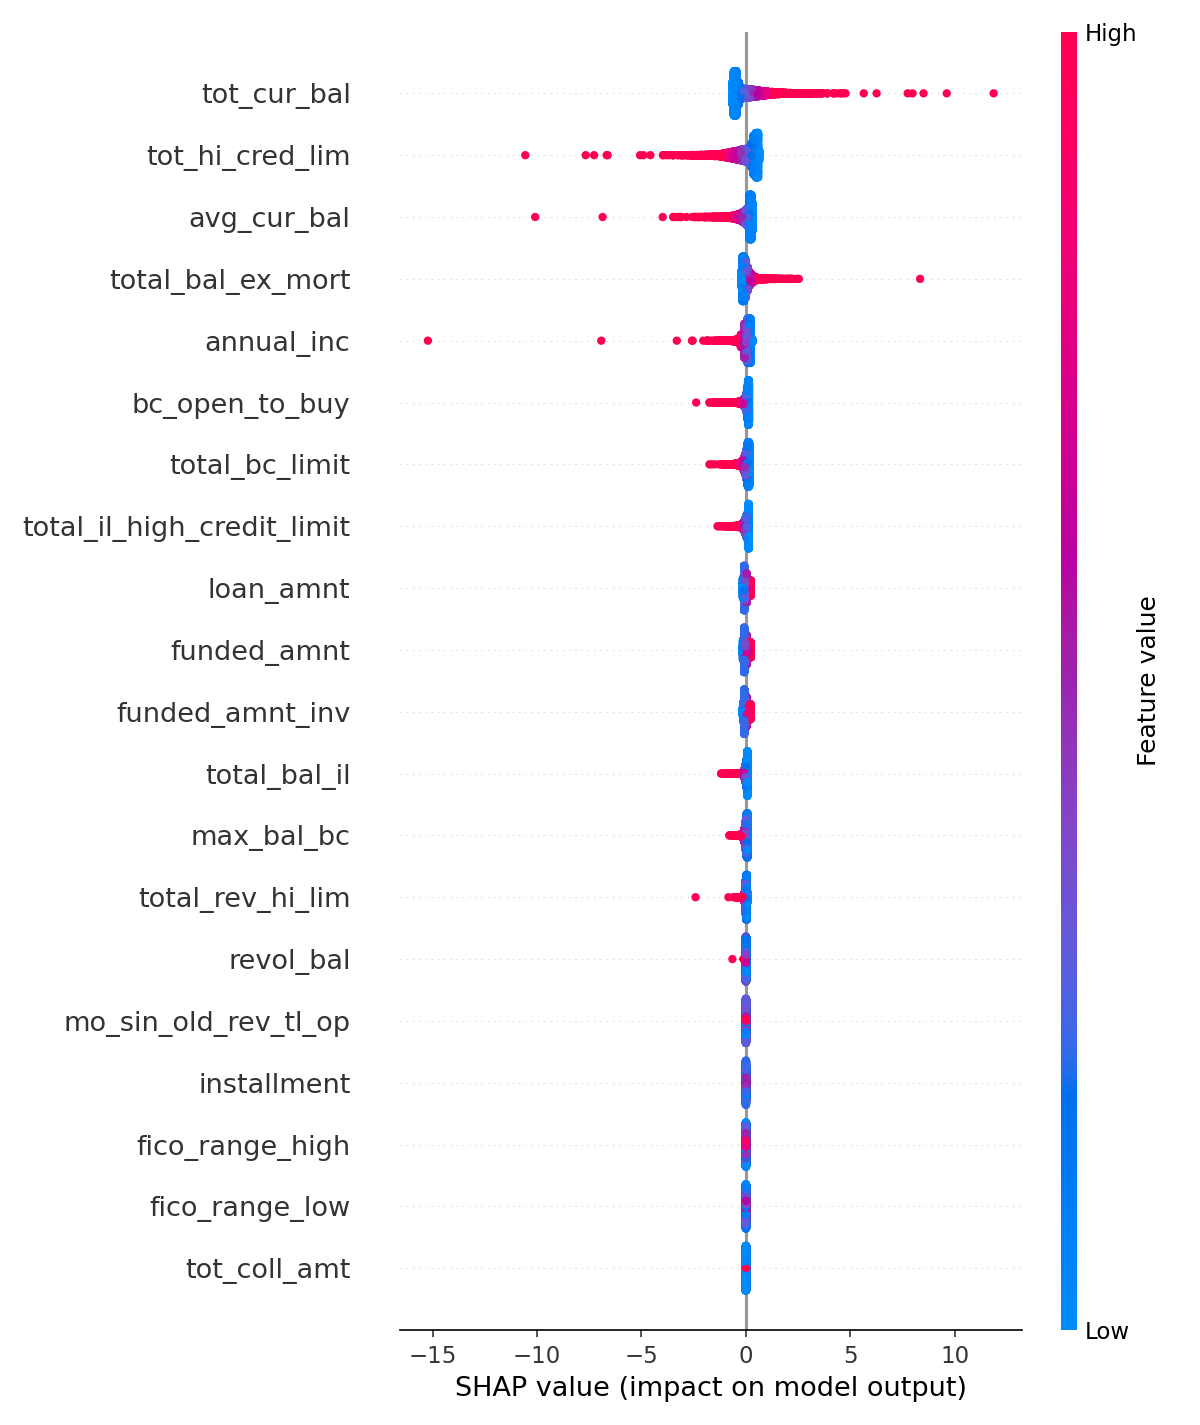

In [30]:
from IPython.display import display, Image

# List of all plot filenames
plot_files = [
    "dep_LGBM_acc_open_past_24mths.png",
    "dep_LGBM_amnt_inc_ratio.png",
    "dep_LGBM_dti.png",
    "dep_LGBM_fico_range_low.png",
    "dep_LGBM_int_rate.png",
    "dep_LGBM_issue_year.png",
    "LGBM_bar.png",
    "LGBM_beeswarm.png",
    "LGBM_PR_curve.png",
    "local_Border_576.png",
    "local_FN_181.png",
    "local_FP_7.png",
    "local_TP_278.png",
    "LogReg_bar.png",
    "LogReg_beeswarm.png"
]

# Display each image
for filename in plot_files:
    display(Image(filename=ART_DIR / filename))
